# Prepare notebook

In [1]:
import json
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
from plotting_utilities import *

# Import data

In [2]:
books = pd.read_pickle('2019112_goodreads_book_data.pkl')
shelves = pd.read_pickle('2019112_goodreads_book_shelves.pkl')
books = books.join(shelves)

categories = pd.read_pickle('2019112_goodreads_book_categories.pkl')
category_mappings = json.load( open("category_mappings.json","r"))
#academic_fields = pd.read_pickle('2019112_goodreads_book_academic_fields.pkl')
#academic_field_mappings = json.load( open("academic_field_mappings.json","r"))

# Initial exploration of the data

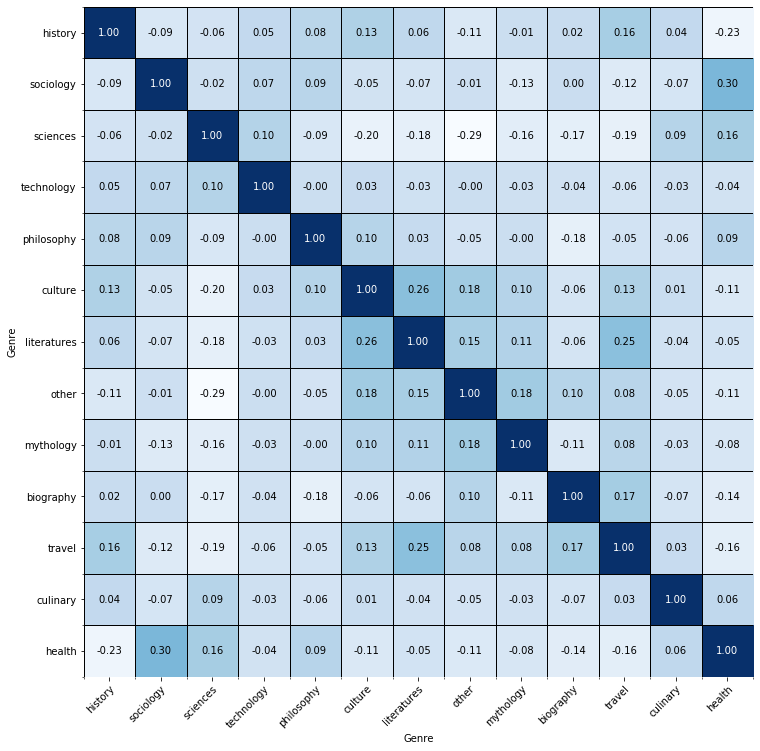

In [3]:
fig, ax = plt.subplots(1,1, figsize = (15,15))
im, cbar = heatmap(categories.corr(), 
                   row_title = 'Genre', row_labels= categories.columns, 
                   col_title = 'Genre', col_labels = categories.columns,
                   ax=ax, cmap='Blues', cbarlabel="Correlation", 
                   x_tick_rotation = 45)
cbar.remove()
cmv = im.get_array().data
texts = annotate_heatmap(im, data = cmv, valfmt="{x:.2f}")

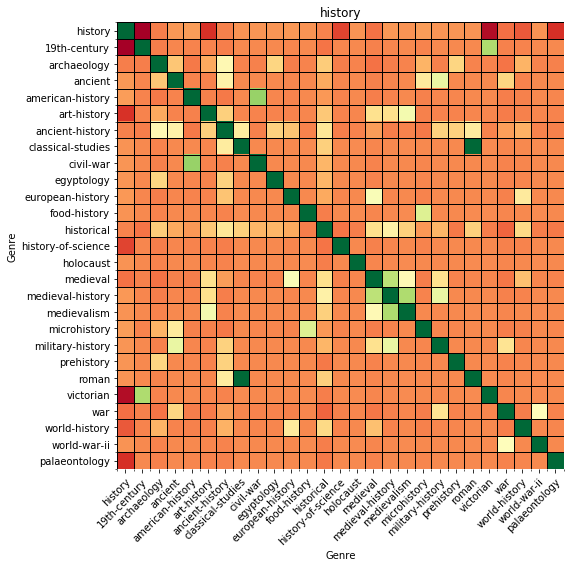

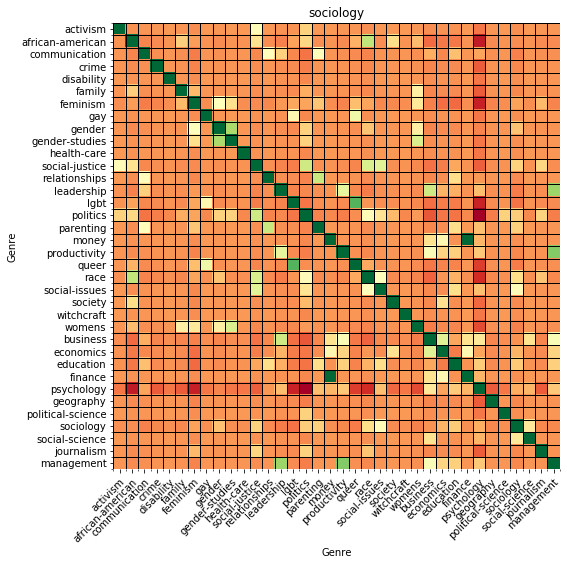

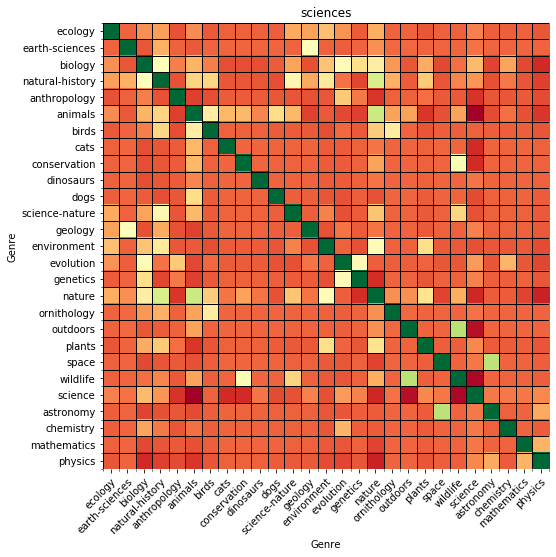

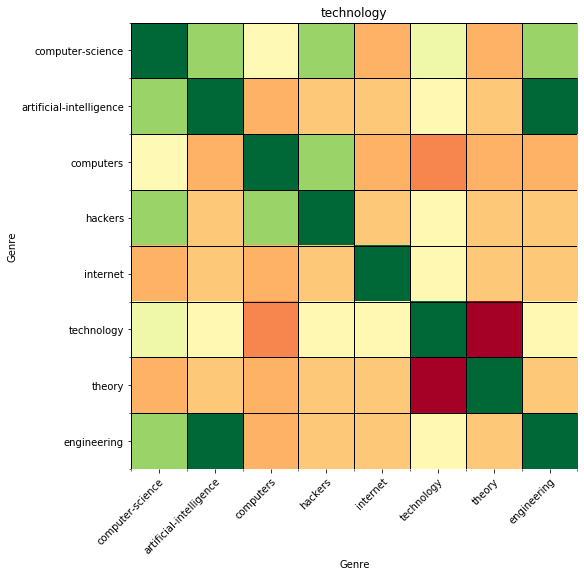

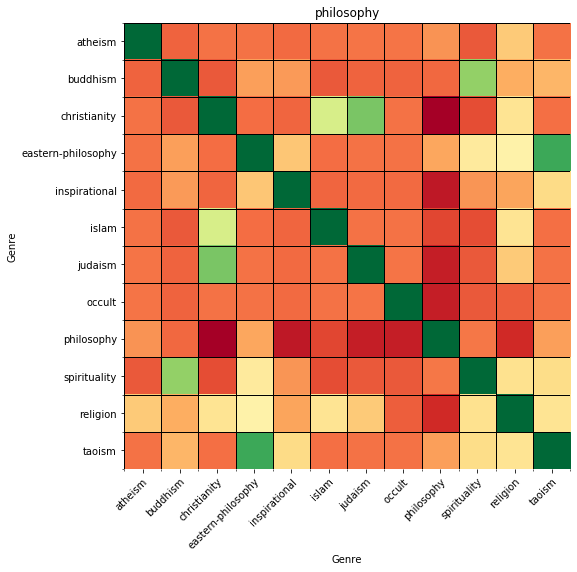

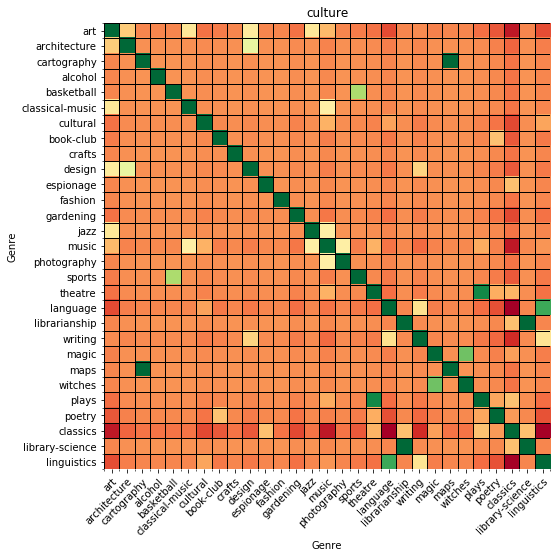

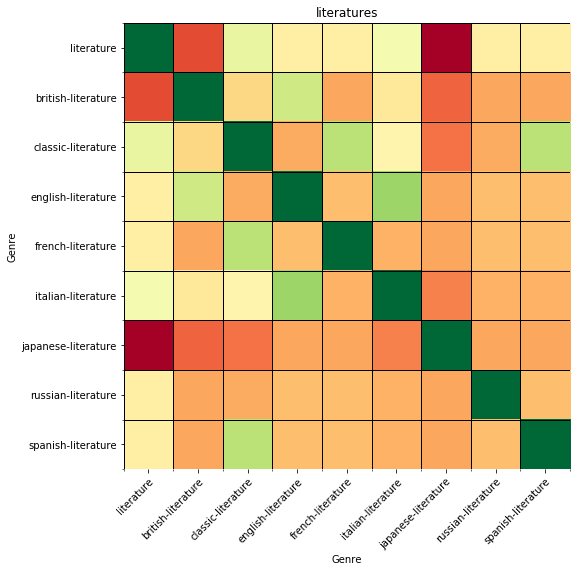

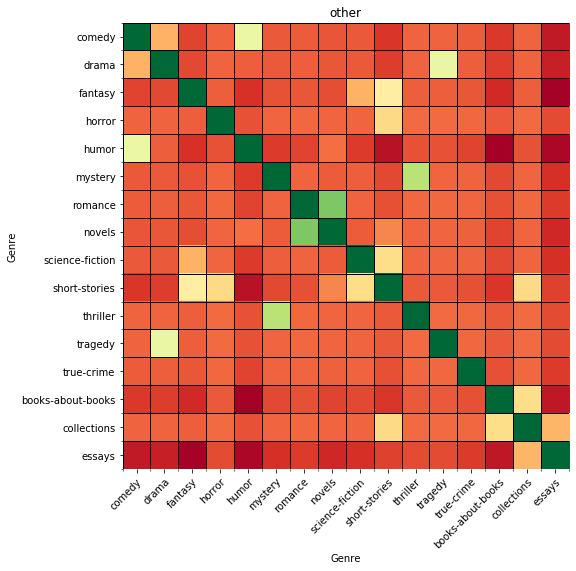

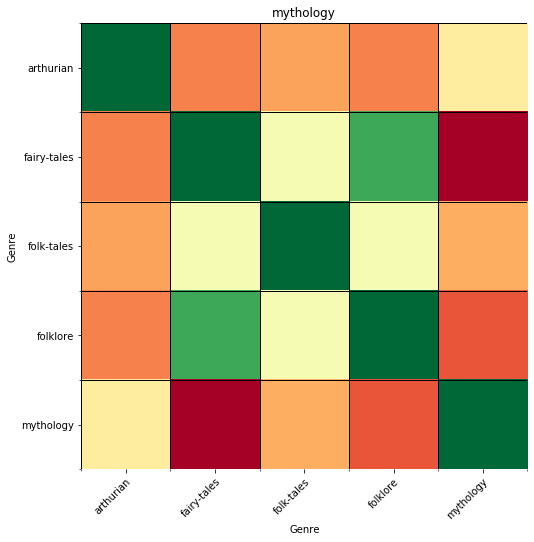

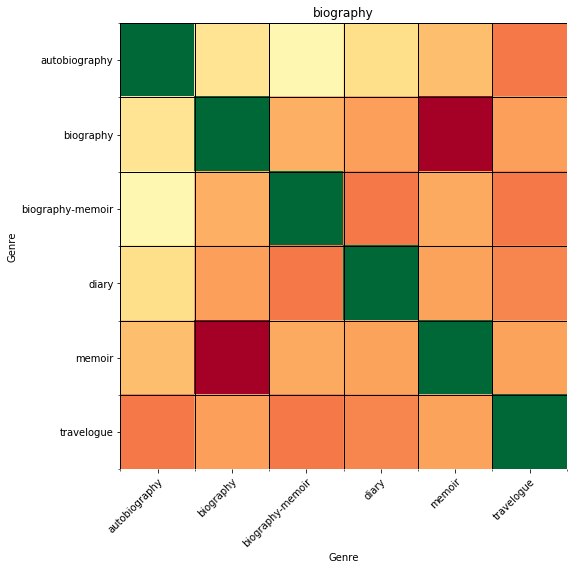

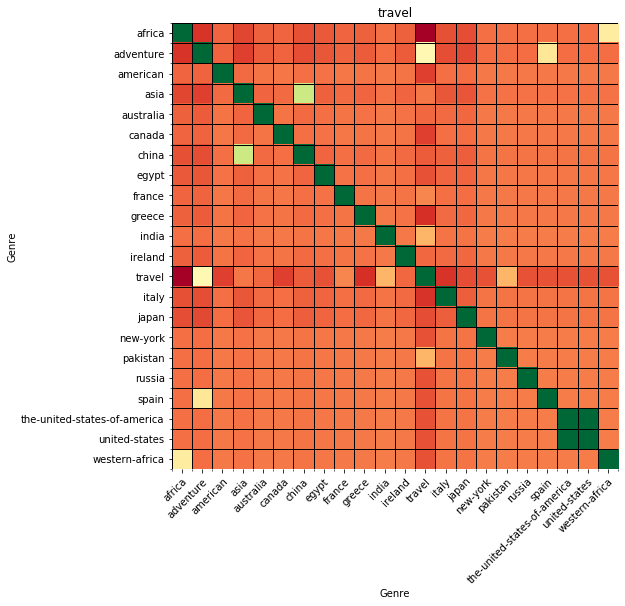

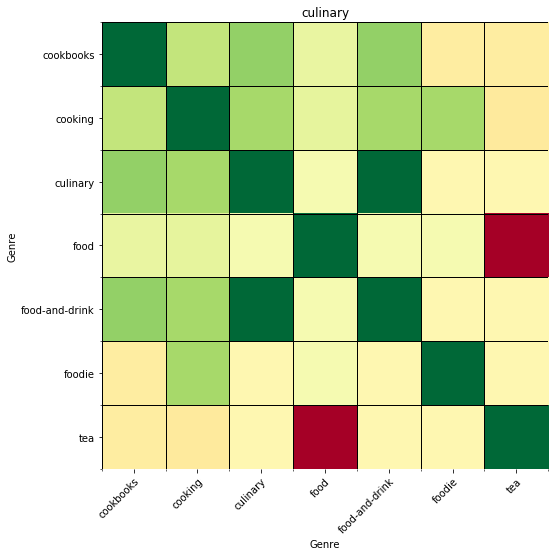

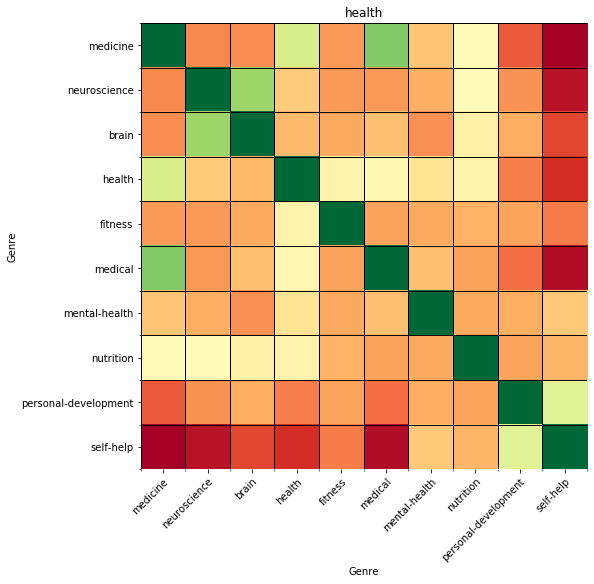

In [4]:
for k,v in category_mappings.items():
    fig, ax = plt.subplots(1,1, figsize = (10,10))
    g = books.loc[categories[k], v]
    ax.set_title(k)
    im, cbar = heatmap(g.astype(int).corr(), 
                   row_title = 'Genre', row_labels= g.columns, 
                   col_title = 'Genre', col_labels = g.columns,
                   ax=ax, cmap='RdYlGn', cbarlabel="Correlation", 
                   x_tick_rotation = 45)
    cbar.remove()
    #cmv = im.get_array().data
    #texts = annotate_heatmap(im, data = cmv, valfmt="{x:.2f}")  

In [5]:
counts = {}
normalized_counts = {}
for c in categories.columns:
    ratings = books.loc[categories[c], 'My Rating']
    counts[c] = ratings.value_counts().to_dict()
    normalized_counts[c] = ratings.value_counts(normalize=True).to_dict()


In [6]:
totals = (pd.DataFrame(counts).T).sum(axis = 1)

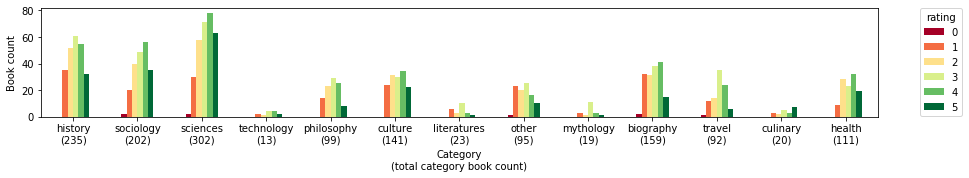

In [7]:
fig, ax = plt.subplots(1,1, figsize = (15,2))
(pd.DataFrame(counts).T).sort_index(axis =1).plot.bar(cmap = 'RdYlGn',ax =ax)
plt.legend(title = 'rating', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xticklabels(['%s\n(%d)'%(i,c) for i,c in totals.iteritems()], rotation = 0);
ax.set_xlabel('Category\n(total category book count)');
ax.set_ylabel('Book count');

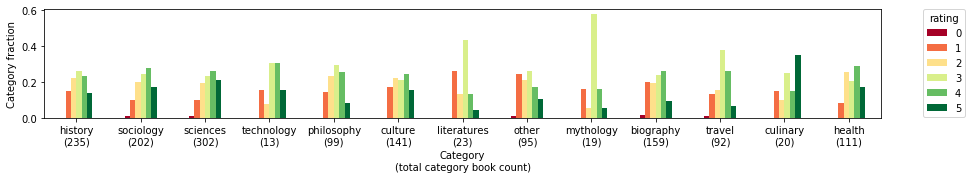

In [8]:
fig, ax = plt.subplots(1,1, figsize = (15,2))
(pd.DataFrame(normalized_counts).T).sort_index(axis =1).plot.bar(cmap = 'RdYlGn',ax =ax)
plt.legend(title = 'rating', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xticklabels(['%s\n(%d)'%(i,c) for i,c in totals.iteritems()], rotation = 0);
ax.set_xlabel('Category\n(total category book count)');
ax.set_ylabel('Category fraction');

AttributeError: 'Rectangle' object has no property 'palettes'

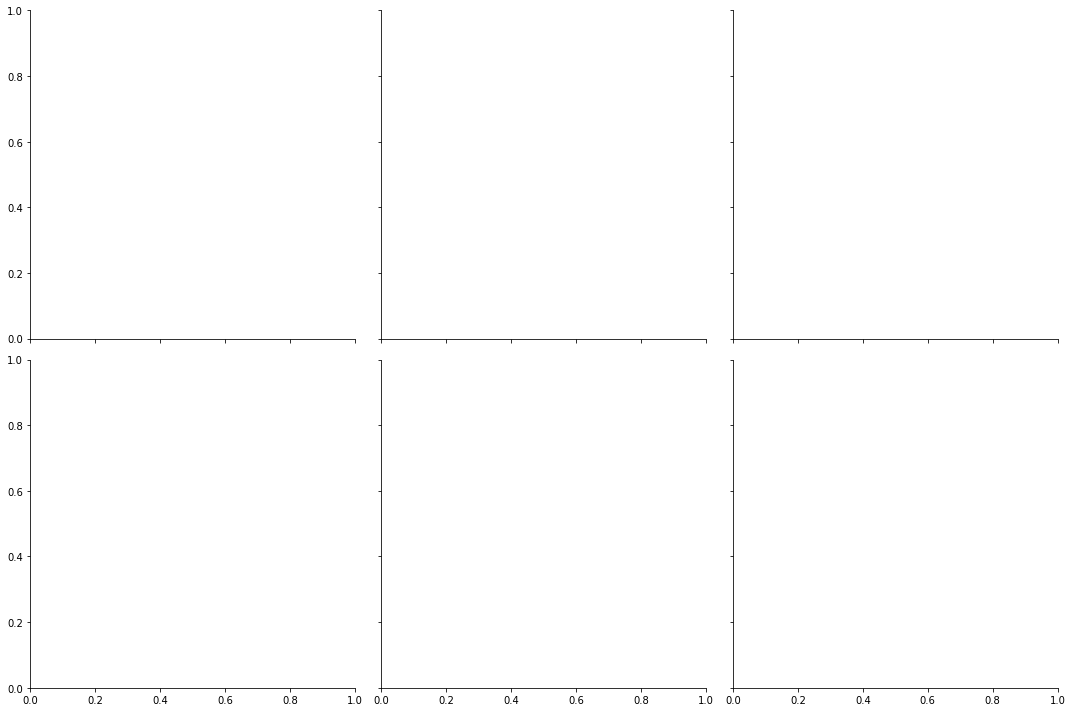

In [9]:
sns.catplot(data = pd.melt(categories.reset_index(), id_vars = ['index'], var_name = 'category')\
                .replace(False, np.nan).dropna(subset = ['value']).fillna(0)\
                .merge(books.reset_index()[['index', 'My Rating']], on = 'index', how = 'left'),
                col ='My Rating', y = 'category', kind = 'count', palettes = 'RdYlGn', col_wrap = 3)
